In [1]:
import os
import time

from collections import Counter

import random
import numpy as np
import pandas as pd
import seaborn as sn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchtext.legacy import data
from torchtext.vocab import Vectors

from tqdm import notebook

from argparse import Namespace

import gensim
from gensim.scripts.glove2word2vec import glove2word2vec

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
args = Namespace(
    dataset_dir = ".data",
    dataset_prefix = "faq_with_splits_",
    datasets = ["lemmatized_filtered", "lemmatized"],
    model_save_dir = ".model_storage/LSTM",
    model_state_file = "model",
    embedding_dir = '.embedding/',
    glove_file = 'glove-hu.200k.200d.txt',
    gensim_file = 'glove-hu.200k.200d_gensim',
    seed = 1234,
    num_epochs = 20,
    learning_rate = 1e-3,
    batch_size = 70,
    cuda = True,
    train_column = 'short_question',
    embedding_dim = 200,
    hidden_dim = 100
)

In [3]:
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device('cuda' if args.cuda & torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
args.model_state_file = os.path.join(args.model_save_dir, args.model_state_file)
args.glove_file = os.path.join(args.embedding_dir, args.glove_file)
args.gensim_file = os.path.join(args.embedding_dir, args.gensim_file)

In [6]:
if not os.path.exists(args.model_save_dir):
    os.makedirs(args.model_save_dir)
    print(f"Created directory {args.model_save_dir}")
else:
    print(f"{args.model_save_dir} directory already exists")

.model_storage/LSTM directory already exists


Download the embedding file from the [here](https://drive.google.com/uc?id=19k2AACA90Qv1BeUBz8H6trCT4QTJ8OjW).   

Store it in the folder called `.embedding`

In [7]:
_ = glove2word2vec(args.glove_file, args.gensim_file)

In [8]:
embedding = gensim.models.KeyedVectors.load_word2vec_format(args.gensim_file, binary=False)

In [9]:
embedding.most_similar("kutya")

[('eb', 0.7757452130317688),
 ('macska', 0.7404807806015015),
 ('állat', 0.7344025373458862),
 ('kábítószerkereső', 0.5937931537628174),
 ('cica', 0.5882569551467896),
 ('házőrző', 0.5795878767967224),
 ('kóbor', 0.5772242546081543),
 ('kutyus', 0.5725077390670776),
 ('ló', 0.5699491500854492),
 ('állatorvos', 0.5556226372718811)]

In [10]:
embedding.most_similar(positive=['nő', 'király'], negative=['férfi'])

[('uralkodó', 0.5323919057846069),
 ('herceg', 0.5205429792404175),
 ('királynő', 0.514873743057251),
 ('szent', 0.5075244903564453),
 ('Mátyás', 0.48192864656448364),
 ('uralkodás', 0.4663204848766327),
 ('királyság', 0.46250832080841064),
 ('Erzsébet', 0.46192696690559387),
 ('trón', 0.4607922434806824),
 ('császár', 0.4557167887687683)]

In [11]:
faq_dataframes = {}

for dataset in args.datasets:
    df_path = os.path.join(args.dataset_dir, args.dataset_prefix + dataset + ".csv")
    print(f"Opening file: {df_path}")
    faq_dataframes[dataset] = pd.read_csv(df_path)

Opening file: .data\faq_with_splits_lemmatized_filtered.csv
Opening file: .data\faq_with_splits_lemmatized.csv


In [12]:
faq_dataframes[args.datasets[0]].head()

,short_question,long_question,answer,main_category,sub_category,split
0,megy hasa kutya mi tehet,megy hasa kutya mi tehet körülbelül hét ismerő...,Kutyának kenyeret? Nem semmi lehet az ismerősö...,Állatok,Kutyák,val
1,ti mot szőrös ruha,ti mot szőrös ruha a gép berakott ruha alap kb...,"A Furminator nevű fésű egy áldás, annyi szőrt ...",Állatok,Kutyák,train
2,részleges körülmetélés nehéz gyógyul begyullad...,részleges körülmetélés nehéz gyógyul begyullad...,Szerintem doki vagy ügyelet... Vagy egy baràt ...,Egészség,Férfiak egészsége,train
3,sos első szemüveg fontos tudnivaló,sos első szemüveg fontos tudnivaló a jobb 0 75...,Semmi köze a szemüveg hordásának vagy nem hord...,Egészség,Szemproblémák,train
4,felpuffadt has megszűnik menstruáció összefüggés,felpuffadt has megszűnik menstruáció összefügg...,"Elsősorban, amikor feleszméltél, h az anorexia...",Egészség,Nők egészsége,train


In [13]:
for dataset in args.datasets:
    faq_dataframes[dataset] = faq_dataframes[dataset][[args.train_column,'main_category', 'split']]

In [14]:
faq_dataframes[args.datasets[0]].head()

,short_question,main_category,split
0,megy hasa kutya mi tehet,Állatok,val
1,ti mot szőrös ruha,Állatok,train
2,részleges körülmetélés nehéz gyógyul begyullad...,Egészség,train
3,sos első szemüveg fontos tudnivaló,Egészség,train
4,felpuffadt has megszűnik menstruáció összefüggés,Egészség,train


In [15]:
target_names = faq_dataframes[args.datasets[0]].main_category.unique().tolist()
target_dict = {k: v for v, k in enumerate(target_names)}

print(target_names)
print(target_dict)

['Állatok', 'Egészség', 'Szórakozás', 'Számítástechnika']
{'Állatok': 0, 'Egészség': 1, 'Szórakozás': 2, 'Számítástechnika': 3}


In [16]:
for dataset in args.datasets:
    faq_dataframes[dataset].main_category = faq_dataframes[dataset].main_category.apply(lambda x: target_dict[x])

In [17]:
faq_dataframes[args.datasets[0]].head()

,short_question,main_category,split
0,megy hasa kutya mi tehet,0,val
1,ti mot szőrös ruha,0,train
2,részleges körülmetélés nehéz gyógyul begyullad...,1,train
3,sos első szemüveg fontos tudnivaló,1,train
4,felpuffadt has megszűnik menstruáció összefüggés,1,train


In [18]:
def get_dataframes_for_split(split, datasets):
    return {ds: datasets[ds][datasets[ds].split == split].drop('split', axis=1) for ds in datasets}

In [19]:
train_dfs = get_dataframes_for_split('train', faq_dataframes)
test_dfs = get_dataframes_for_split('test', faq_dataframes)
valid_dfs = get_dataframes_for_split('val', faq_dataframes)

In [20]:
train_dfs[args.datasets[0]].head()

,short_question,main_category
1,ti mot szőrös ruha,0
2,részleges körülmetélés nehéz gyógyul begyullad...,1
3,sos első szemüveg fontos tudnivaló,1
4,felpuffadt has megszűnik menstruáció összefüggés,1
5,nos szombathely kell darázsfész eltávolít lega...,0


In [21]:
vectors = Vectors(args.gensim_file)

In [23]:
fields = {}

for key in args.datasets:
    QUESTION = data.Field(tokenize = 'spacy', tokenizer_language = 'hu_core_ud_lg')
    TARGET = data.LabelField(dtype = torch.long)
    fields[key] = [(args.train_column, QUESTION),('main_category', TARGET)]

In [24]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.main_category
            text = row.short_question
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

In [25]:
def create_dataframe_datasets(dfs, fields):
    dataframe_datasets = {}
    for key in dfs:
        dataframe_datasets[key] = DataFrameDataset(df = dfs[key], fields = fields[key])
    return dataframe_datasets

In [26]:
train_datasets = create_dataframe_datasets(train_dfs, fields)
valid_datasets = create_dataframe_datasets(valid_dfs, fields)
test_datasets = create_dataframe_datasets(test_dfs, fields = fields)

In [27]:
for key in fields:
    fields[key][0][1].build_vocab(train_datasets[key], vectors = vectors)  
    fields[key][1][1].build_vocab(train_datasets[key])  

In [28]:
field_ = fields['lemmatized'][0][1]
field_.vocab.stoi['kutya']

20

In [29]:
vectors.stoi['kutya']

1782

In [30]:
torch.equal(field_.vocab.vectors[20], vectors.vectors[1782])

True

In [31]:
def create_iterators(train_ds, valid_ds, test_ds):
    iterators = {}
    
    for key in args.datasets:
        iterators[key] = data.BucketIterator.splits((train_ds[key], valid_ds[key], test_ds[key]),
                batch_size = args.batch_size,
                sort_key = lambda x: len(x.short_question),
                sort_within_batch = False,
                device = device)
    return iterators

In [32]:
iterators = create_iterators(train_datasets, valid_datasets, test_datasets)

In [33]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, field):
        super(LSTMClassifier, self).__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embedding.weight.data.copy_(field.vocab.vectors)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.lstm(embedded)
        y = self.fc(output[-1])       
        log_probs = F.log_softmax(y.squeeze(0), dim=1)
        return log_probs

In [34]:
def class_accuracy(preds, y):
    rounded_preds = preds.argmax(1)
    correct = (rounded_preds == y).float()

    acc = correct.sum() / len(correct)
    return acc

In [35]:
def show_data_to_model(model, iterator, optimizer, criterion, bar, train):
    epoch_loss = 0
    epoch_acc = 0
       
    total_predicted = []
    
    for idx, batch in enumerate(iterator):      
        if train:
            optimizer.zero_grad()

        predictions = model(batch._get_field_values(batch.input_fields))
        loss = criterion(predictions, batch.main_category)
        acc = class_accuracy(predictions, batch.main_category)
        if train:
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        _, predicted = torch.max(predictions.data, 1)
        total_predicted += predicted.tolist()
        
        bar.set_postfix(loss=(epoch_loss / (idx + 1)), acc=(epoch_acc / (idx + 1)))
        bar.update()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), total_predicted

In [36]:
def train_model(model, iterator, optimizer, criterion, bar):
    model.train()
    loss, acc, _ = show_data_to_model(model, iterator, optimizer, criterion, bar, True)
    
    return loss, acc

In [37]:
def evaluate_model(model, iterator, optimizer, criterion, bar):
    model.eval()
    with torch.no_grad():
        loss, acc, predicted = show_data_to_model(model, iterator, optimizer, criterion, bar, False)
            
    return loss, acc, predicted

In [38]:
train_losses = {}
train_accuracies = {}

valid_losses = {}
valid_accuracies = {}

for dataset_key in args.datasets:
    start_time = int(time.time() * 1000)
    
    best_valid_loss = float('inf')
    
    train_losses[dataset_key] = []
    train_accuracies[dataset_key] = []

    valid_losses[dataset_key] = []
    valid_accuracies[dataset_key] = []
    
    train_iterator, valid_iterator, _ = iterators[dataset_key]
    
    question_field = fields[key][0][1]
    input_dim = len(question_field.vocab)
    output_dim = len(target_names)
    
    model = LSTMClassifier(input_dim, args.embedding_dim, args.hidden_dim, output_dim, question_field)
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    criterion = nn.NLLLoss()

    model = model.to(device)
    criterion = criterion.to(device)
    
    epoch_bar = notebook.tqdm(desc=f"'{dataset_key}' epoch", total=args.num_epochs, position=0, leave=True)
    train_bar = notebook.tqdm(desc=f"'{dataset_key}' train", total=len(train_iterator), position=0, leave=False)
    valid_bar = notebook.tqdm(desc=f"'{dataset_key}' valid", total=len(valid_iterator), position=0, leave=False)
        
    for epoch in range(args.num_epochs):
        train_bar.n = 0
        valid_bar.n = 0
        
        train_bar.refresh()
        valid_bar.refresh()

        train_loss, train_acc = train_model(model, train_iterator, optimizer, criterion, train_bar)
        valid_loss, valid_acc, _ = evaluate_model(model, valid_iterator, optimizer, criterion, valid_bar)

        train_losses[dataset_key].append(train_loss)
        train_accuracies[dataset_key].append(train_acc)

        valid_losses[dataset_key].append(valid_loss)
        valid_accuracies[dataset_key].append(valid_acc)
    
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), args.model_state_file + "_" + dataset_key + ".pth")
 
        epoch_bar.update()

'lemmatized_filtered' epoch:   0%|          | 0/20 [00:00<?, ?it/s]

'lemmatized_filtered' train:   0%|          | 0/1536 [00:00<?, ?it/s]

'lemmatized_filtered' valid:   0%|          | 0/330 [00:00<?, ?it/s]

'lemmatized' epoch:   0%|          | 0/20 [00:00<?, ?it/s]

'lemmatized' train:   0%|          | 0/1536 [00:00<?, ?it/s]

'lemmatized' valid:   0%|          | 0/330 [00:00<?, ?it/s]

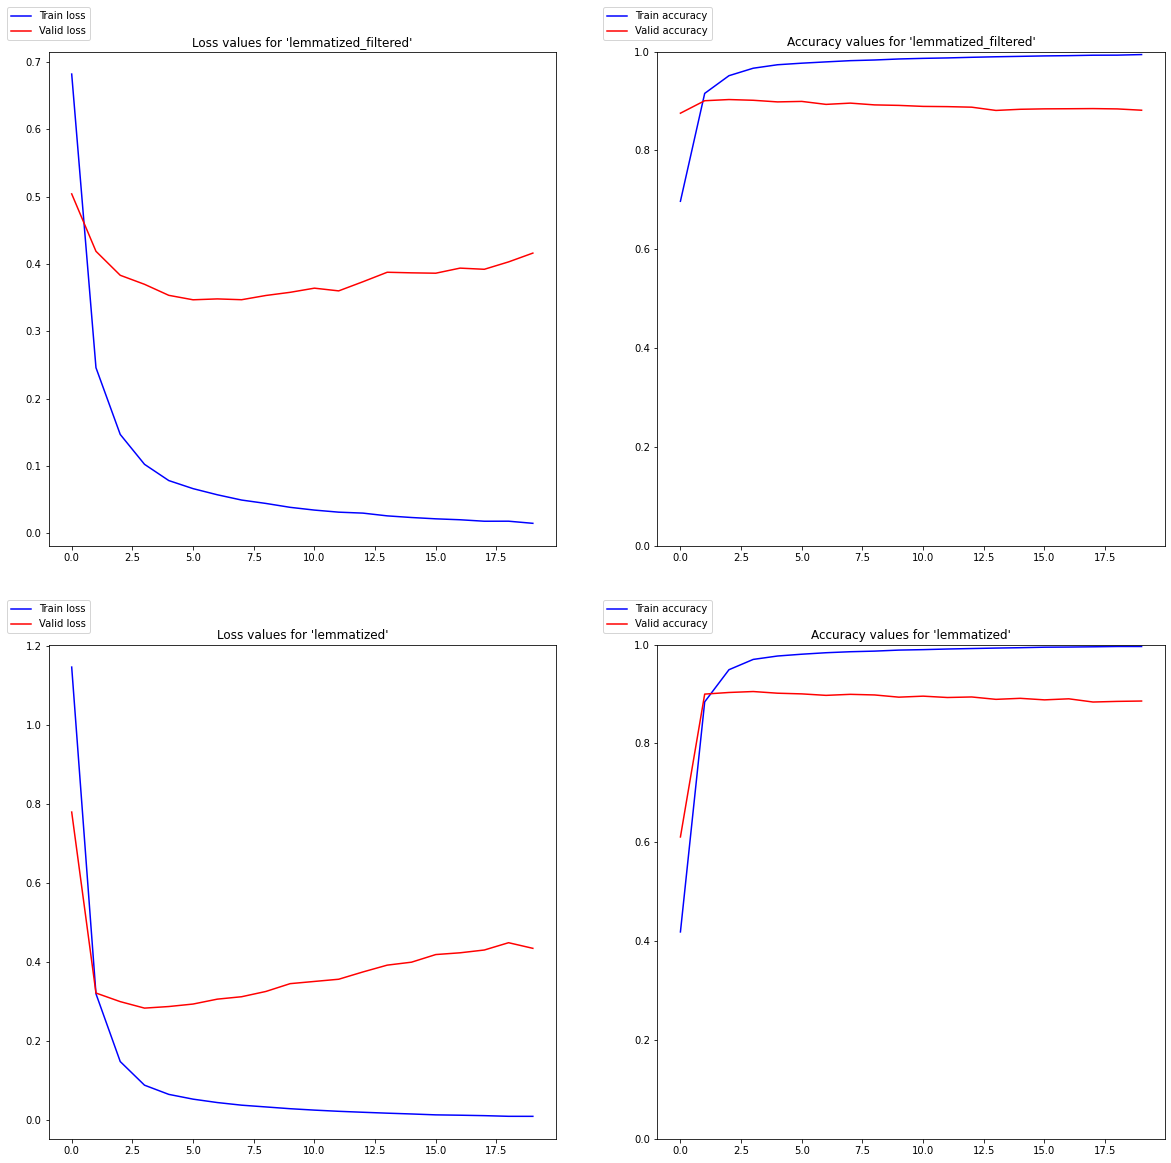

In [40]:
fig, axs = plt.subplots(len(args.datasets), 2, figsize=(10 * 2, 10 * len(args.datasets)))

for idx, dataset in enumerate(args.datasets):
    axs[idx, 0].set_title(f"Loss values for '{dataset}'")
    axs[idx, 0].plot([*range(args.num_epochs)], train_losses[dataset], color = 'b', label='Train loss')
    axs[idx, 0].plot([*range(args.num_epochs)], valid_losses[dataset], color = 'r', label='Valid loss')
    axs[idx, 0].legend(loc="upper center", bbox_to_anchor=(0.0, 1.1), ncol=1)
    
    axs[idx, 1].set_title(f"Accuracy values for '{dataset}'")
    axs[idx, 1].axis(ymin = 0, ymax = 1)
    axs[idx, 1].plot([*range(args.num_epochs)], train_accuracies[dataset], color = 'b', label='Train accuracy')
    axs[idx, 1].plot([*range(args.num_epochs)], valid_accuracies[dataset], color = 'r', label='Valid accuracy')
    axs[idx, 1].legend(loc="upper center", bbox_to_anchor=(0.0, 1.1), ncol=1)
    
plt.show()

In [41]:
predictions = {}
test_target = {}

for dataset_key in args.datasets:
    _, _, test_iterator = iterators[dataset_key]
    
    question_field = fields[key][0][1]
    input_dim = len(question_field.vocab)
    output_dim = len(target_names)
    
    model = LSTMClassifier(input_dim, args.embedding_dim, args.hidden_dim, output_dim, question_field)
    
    test_bar = notebook.tqdm(desc=f"'{dataset_key}' test", total=len(test_iterator), position=0, leave=True)

    model.load_state_dict(torch.load(args.model_state_file + "_" + dataset_key + ".pth"))
    model = model.to(device)

    _, _, predictions[dataset_key] = evaluate_model(model, test_iterator, optimizer, criterion, test_bar)
    
    temp = []
    for batch in test_iterator:
        temp += batch.main_category.tolist()
        
    test_target[dataset_key] = [fields[dataset_key][1][1].vocab[val] for val in temp]    
    predictions[dataset_key] = [fields[dataset_key][1][1].vocab[val] for val in predictions[dataset_key]]

'lemmatized_filtered' test:   0%|          | 0/330 [00:00<?, ?it/s]

'lemmatized' test:   0%|          | 0/330 [00:00<?, ?it/s]

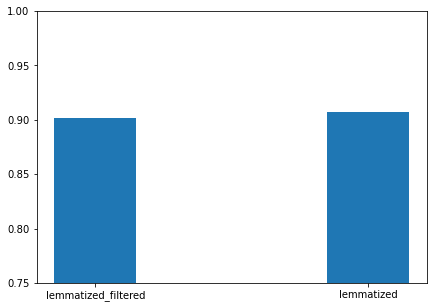

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
accuracy_scores = []

for dataset in args.datasets:
    pred = predictions[dataset]
    accuracy_scores.append(accuracy_score(test_target[dataset], pred))
    
ax.axis(ymin = 0.75, ymax = 1)
ax.bar(args.datasets, accuracy_scores, width=0.3)

plt.show()

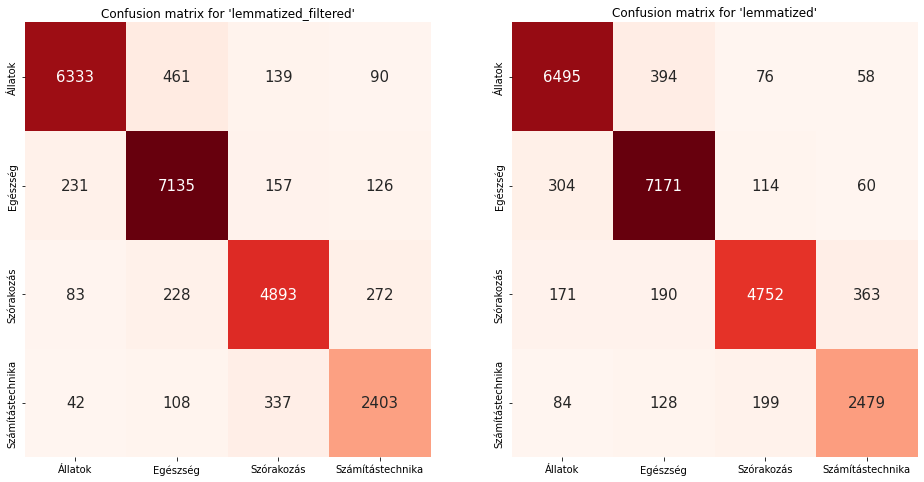

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4 * len(args.datasets)))

for idx, dataset_key in enumerate(args.datasets):
    axs[idx % 2].set_title(f"Confusion matrix for '{dataset_key}'")
    
    pred = predictions[dataset_key]
    cm = confusion_matrix(test_target[dataset_key], pred)
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    
    heatmap = sn.heatmap(cm_df, annot=True, ax=axs[idx % 2], cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)

plt.show()

In [44]:
for dataset_key in args.datasets:
    pred = predictions[dataset_key]
    report = classification_report(test_target[dataset_key], pred, target_names=target_names)
    print(f"Classification report for '{dataset_key}':\n{report}\n{'=' * 60}")

Classification report for 'lemmatized_filtered':
                  precision    recall  f1-score   support

         Állatok       0.95      0.90      0.92      7023
        Egészség       0.90      0.93      0.92      7649
      Szórakozás       0.89      0.89      0.89      5476
Számítástechnika       0.83      0.83      0.83      2890

        accuracy                           0.90     23038
       macro avg       0.89      0.89      0.89     23038
    weighted avg       0.90      0.90      0.90     23038

Classification report for 'lemmatized':
                  precision    recall  f1-score   support

         Állatok       0.92      0.92      0.92      7023
        Egészség       0.91      0.94      0.92      7649
      Szórakozás       0.92      0.87      0.90      5476
Számítástechnika       0.84      0.86      0.85      2890

        accuracy                           0.91     23038
       macro avg       0.90      0.90      0.90     23038
    weighted avg       0.91      0.9